In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 普通の学習での出力計算

In [2]:
def inference(condition_placeholder,keep_prob):#普通の学習におけるニューラルネットの計算
  with tf.name_scope("hidden1") as scope:#入力層→中間層の計算を行う
    hidden1_output = tf.nn.relu(tf.matmul(condition_placeholder, hidden1_weight) + hidden1_bias)
    hidden1_output = tf.nn.dropout(hidden1_output,keep_prob)
  with tf.name_scope("output") as scope:#中間層→出力層の計算を行う
    output = tf.matmul(hidden1_output, output_weight) + output_bias
    output = tf.nn.dropout(output,keep_prob)
  return tf.nn.l2_normalize(output, 0)#正規化

### 積分表現理論を利用した学習での出力計算

In [3]:

def inference_oracle(condition_placeholder,keep_prob):#リッジレットにおけるニューラルネットの計算

  with tf.name_scope("hidden1_oracle") as scope:#入力層→中間層の計算を行う

    hidden1_output = tf.nn.relu(tf.matmul(condition_placeholder, hidden1_oracle_weight) + hidden1_oracle_bias)

    hidden1_output = tf.nn.dropout(hidden1_output,keep_prob)

  with tf.name_scope("output_oracle") as scope:#中間層→出力層の計算を行う

    output = tf.matmul(hidden1_output, tf.transpose(output_oracle_weight)) + output_oracle_bias

    output = tf.nn.dropout(output,keep_prob)

  return tf.nn.l2_normalize(output, 0)#正規化

### 通常の学習における損失計算と、積分利用での損失計算

In [4]:
def loss(output, label_placeholder):

  with tf.name_scope("loss") as scope:#正規化したうえで損失関数を計算する

    loss = tf.nn.l2_loss(output - tf.nn.l2_normalize(label_placeholder, 0))

    tf.summary.scalar("loss", loss)

  return loss



def loss_oracle(output_oracle, label_placeholder):

  with tf.name_scope("loss_oracle") as scope:#正規化したうえで損失関数を計算する

    loss = tf.nn.l2_loss(output_oracle - tf.nn.l2_normalize(label_placeholder, 0))

    tf.summary.scalar("loss_oracle", loss)

  return loss

### 通常の学習とリッジレット解析を用いた学習

In [5]:
def training(loss):#本番の学習

  with tf.name_scope("training") as scope:

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss,var_list=[hidden1_weight,hidden1_bias,output_weight,output_bias])

  return train_step



def training_oracle(loss_oracle):#リッジレット解析における本番の学習

  with tf.name_scope("training_oracle") as scope:

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss_oracle,var_list=[hidden1_oracle_weight,hidden1_oracle_bias,output_oracle_weight,output_oracle_bias])

  return train_step

### 独自の工夫（オラクルサンプリング）に必要な混合比サンプリング

In [6]:
def w_sample():#独特な工夫その２．混合比サンプリング

    w = np.random.rand()

    sum_y_j = 0

    for j in range(data_size):

        sum_y_j += np.absolute(label_train[j][0])

        if w < sum_y_j/y_sum:

            break

    return j

### オラクルサンプリングの本体

In [7]:
def oracle_sampling():#独特な工夫その１。オラクルサンプリング。

    a_b_list=[[None for i in range(CONDITION_SIZE+1)] for j in range(HIDDEN_UNIT_SIZE)]

    

    for j in range(HIDDEN_UNIT_SIZE):

        s=w_sample()

        t=w_sample()

        if s==t:#もし番号がかぶったら選びなおし

            t=w_sample()

            if s==t:

                t=w_sample()

        xi=np.random.beta(100,3)

        gamma=np.random.binomial(1,0.5)

        z=xi*np.power(-1,gamma)

        a_inv=norm(condition_train[s]-condition_train[t])

        norm_s=norm(condition_train[s])

        nor_sum=0 #内積の保存

        for i in range(CONDITION_SIZE):

            a_b_list[j][i] = condition_train[s][i]/(a_inv*norm_s)

            nor_sum +=  a_b_list[j][i]*condition_train[s][i]

            a_b_list[j][CONDITION_SIZE] = nor_sum-z

    return a_b_list

### ノルムを計算する関数と、リッジレット関数を計算する関数
（なぜリッジレット関数がこうなるのかは[1]と、train.csvを参照。ヒルベルト変換は次元（機械学習で言うと入力層の次元）が偶数なら非常に楽）

In [8]:
def norm(normar):#L2ノルムを計算する

    norm_sum = 0

    for i in range(normar.shape[0]):

        norm_sum += np.power(normar[i],2)

    return np.power(norm_sum,0.5)



def ridgelet_func(x):#リッジレット関数の計算

    return (x*x-1)*np.exp(-x*x/2)

### リッジレット変換の近似

In [9]:
def ridgelet(a,b,label_train,i):#リッジレット変換の近似

    ri_sum = 0

    for j in range(TRAIN_DATA_SIZE):

        ri_sum += ridgelet_func(np.dot(a,condition_train[j])-b)

    return ri_sum[0]/TRAIN_DATA_SIZE

### 初期設定

In [10]:
#ノード数の設定と訓練データの個数設定

HIDDEN_UNIT_SIZE =10000

TRAIN_DATA_SIZE = 1000

### データの読み込みと分割

In [11]:
raw_input = np.loadtxt(open(r"train.csv"), delimiter=",",skiprows=1,dtype = 'float')

CONDITION_SIZE = raw_input.shape[1]-1

[condition,label]  = np.hsplit(raw_input, [CONDITION_SIZE])

[condition_train,condition_test]=np.vsplit(condition,[TRAIN_DATA_SIZE])

[label_train,label_test]=np.vsplit(label,[TRAIN_DATA_SIZE])

### 損失を記録しておく配列

In [12]:
losstrain = []

losstest = []

losstrain_oracle = []

losstest_oracle = []

### オラクルサンプリングとリッジレット変換

In [13]:
data_size = label_train.shape[0]

y_sum=0

c=[]

for i in range(data_size):

    y_sum += np.absolute(float(label_train[i][0]))



para = oracle_sampling() #オラクルサンプリングを行う

[a,b] = np.hsplit(np.array(para), [CONDITION_SIZE])#重みとバイアスに分ける



for i in range(HIDDEN_UNIT_SIZE):

    c.append(ridgelet(a[i],b[i],label_train,i))#リッジレット変換の近似を計算する（定数倍は無視）



### 学習の本体

In [14]:
with tf.Graph().as_default():

  condition_placeholder = tf.placeholder("float", [None, CONDITION_SIZE], name="condition_placeholder")

  label_placeholder = tf.placeholder("float", [None, 1], name="label_placeholder")

  loss_label_placeholder = tf.placeholder("string", name="loss_label_placeholder")

  keep_prob = tf.placeholder("float")

  feed_dict_train={

    label_placeholder: label_train,

    condition_placeholder: condition_train,

    loss_label_placeholder: "loss__normal_train",

    keep_prob : 0.5#ドロップアウト率の設定

  }

  feed_dict_test={

    label_placeholder: label_test,

    condition_placeholder: condition_test,

    loss_label_placeholder: "loss_normal_test",

    keep_prob : 1.0#ドロップアウト率の設定

  }

  feed_dict_oracle_train={#リッジレット解析を用いるほう

    label_placeholder: label_train,

    condition_placeholder: condition_train,

    loss_label_placeholder: "loss__oracle_train",

    keep_prob : 0.5#ドロップアウト率の設定

  }

  feed_dict_oracle_test={

    label_placeholder:label_test,

    condition_placeholder: condition_test,

    loss_label_placeholder: "loss_oracle_test",

    keep_prob : 1.0#ドロップアウト率の設定

  }

  

  #普通の学習に用いる変数

  hidden1_weight = tf.Variable(tf.truncated_normal([CONDITION_SIZE, HIDDEN_UNIT_SIZE], stddev=0.1), name="hidden1_weight")

  hidden1_bias = tf.Variable(tf.constant(0.1, shape=[HIDDEN_UNIT_SIZE]), name="hidden1_bias")

  output_weight = tf.Variable(tf.truncated_normal([HIDDEN_UNIT_SIZE, 1], stddev=0.1), name="output_weight")

  output_bias = tf.Variable(tf.constant(0.1, shape=[1]), name="output_bias") 

  #リッジレット解析を用いた学習に用いる変数

  hidden1_oracle_weight = tf.Variable(a.T, name="hidden1_oracle_weight",dtype=tf.float32)#

  hidden1_oracle_bias = tf.Variable(b.T, name="hidden1_oracle_bias",dtype=tf.float32)

  output_oracle_weight = tf.Variable([c], name="output_oracle_weight",dtype=tf.float32)

  output_oracle_bias = tf.Variable(tf.constant(0.0, shape=[1]), name="output_oracle_bias",dtype=tf.float32)

  #設定

  output = inference(condition_placeholder,keep_prob)

  output_oracle = inference_oracle(condition_placeholder,keep_prob)

  loss = loss(output, label_placeholder)

  loss_oracle = loss_oracle(output_oracle, label_placeholder)

  training_op = training(loss)

  training_rid = training_oracle(loss_oracle)

  summary_op = tf.summary.merge_all()

  init = tf.global_variables_initializer()

  with tf.Session() as sess:

      summary_writer = tf.summary.FileWriter('data',graph=sess.graph )

      sess.run(init)

      #普通の学習

      for step in range(1000):

          sess.run(training_op, feed_dict=feed_dict_train)

          loss_test = sess.run(loss, feed_dict=feed_dict_test)

          loss_train = sess.run(loss, feed_dict=feed_dict_train)

          losstrain.append(loss_train)

          losstest.append(loss_test)

          if step % 100==0:

              summary_str = sess.run(summary_op, feed_dict_test)

              summary_str += sess.run(summary_op, feed_dict=feed_dict_train)

              summary_writer.add_summary(summary_str, step)

              print(loss_train)       

      print(sess.run(loss, feed_dict=feed_dict_test))

      print("ここからリッジレット解析を利用した場合")

      #リッジレット解析を用いた場合

      for step in range(1000):

          sess.run(training_rid, feed_dict=feed_dict_oracle_train)

          loss_test = sess.run(loss_oracle, feed_dict=feed_dict_oracle_test)

          loss_train = sess.run(loss_oracle, feed_dict=feed_dict_oracle_train)

          losstrain_oracle.append(loss_train)

          losstest_oracle.append(loss_test)

          if step % 100==0:

              summary_str = sess.run(summary_op, feed_dict=feed_dict_oracle_test)

              summary_str += sess.run(summary_op, feed_dict=feed_dict_oracle_train)

              summary_writer.add_summary(summary_str, step)

              print(loss_train)       

      print(sess.run(loss_oracle, feed_dict=feed_dict_oracle_test))

0.451956
0.387618
0.360831
0.323083
0.363732
0.35304
0.338354
0.330836
0.323119
0.3381
0.0483926
ここからリッジレット解析を利用した場合
1.46493
0.320151
0.318675
0.322345
0.328422
0.317803
0.314365
0.299446
0.318618
0.325496
0.0303291


### 描画

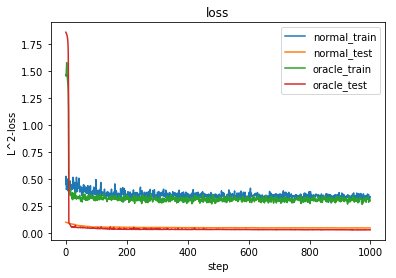

In [15]:
plt.plot(losstrain,label="normal_train")

plt.plot(losstest,label="normal_test") 

plt.plot(losstrain_oracle,label="oracle_train")

plt.plot(losstest_oracle,label="oracle_test") 

plt.legend()

plt.title("loss")

plt.xlabel("step")

plt.ylabel("L^2-loss")

plt.show()